In [140]:
from pathlib import Path
import re

from matplotlib import pyplot as plt
from numpy import nan
import pandas as pd
import torch

%matplotlib inline

SMALL_SIZE = 13
MEDIUM_SIZE = 18
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

DIRECTORY_PATH = Path("./data/measure_run_time")
DATA_FILE_PATH = DIRECTORY_PATH / "experiments.csv"
COVAR_DIR_PATH = DIRECTORY_PATH / "experiments_covariances"

In [141]:
df = pd.read_csv(DATA_FILE_PATH, index_col=0)
df = df[df.exception.isnull()].drop(columns="exception")
data_points = []
gp_id = []
for run_id in df.index:
    m = re.search(r"N([0-9]+)_(.+)", run_id)
    if m is not None:
        data_points.append(int(m.group(1)))
        gp_id.append(m.group(2))
    else:
        data_points.append(nan)
        gp_id.append(nan)

df["data_points"] = data_points
df["gp_id"] = gp_id
df

,run_time,data_points,gp_id
run_id,,,
N1000_n0_Cholesky_cuda,7.329352,1000,n0_Cholesky_cuda
N1000_n0_mBCG_cuda,2.569687,1000,n0_mBCG_cuda
N1000_n50_mBCG_cuda,20.936553,1000,n50_mBCG_cuda
N1000_n100_mBCG_cuda,22.019157,1000,n100_mBCG_cuda
N1000_n150_mBCG_cuda,22.545230,1000,n150_mBCG_cuda
...,...,...,...
N13000_n50_mBCG_cpu,38.546030,13000,n50_mBCG_cpu
N13000_n100_mBCG_cpu,50.707604,13000,n100_mBCG_cpu
N13000_n150_mBCG_cpu,62.896751,13000,n150_mBCG_cpu


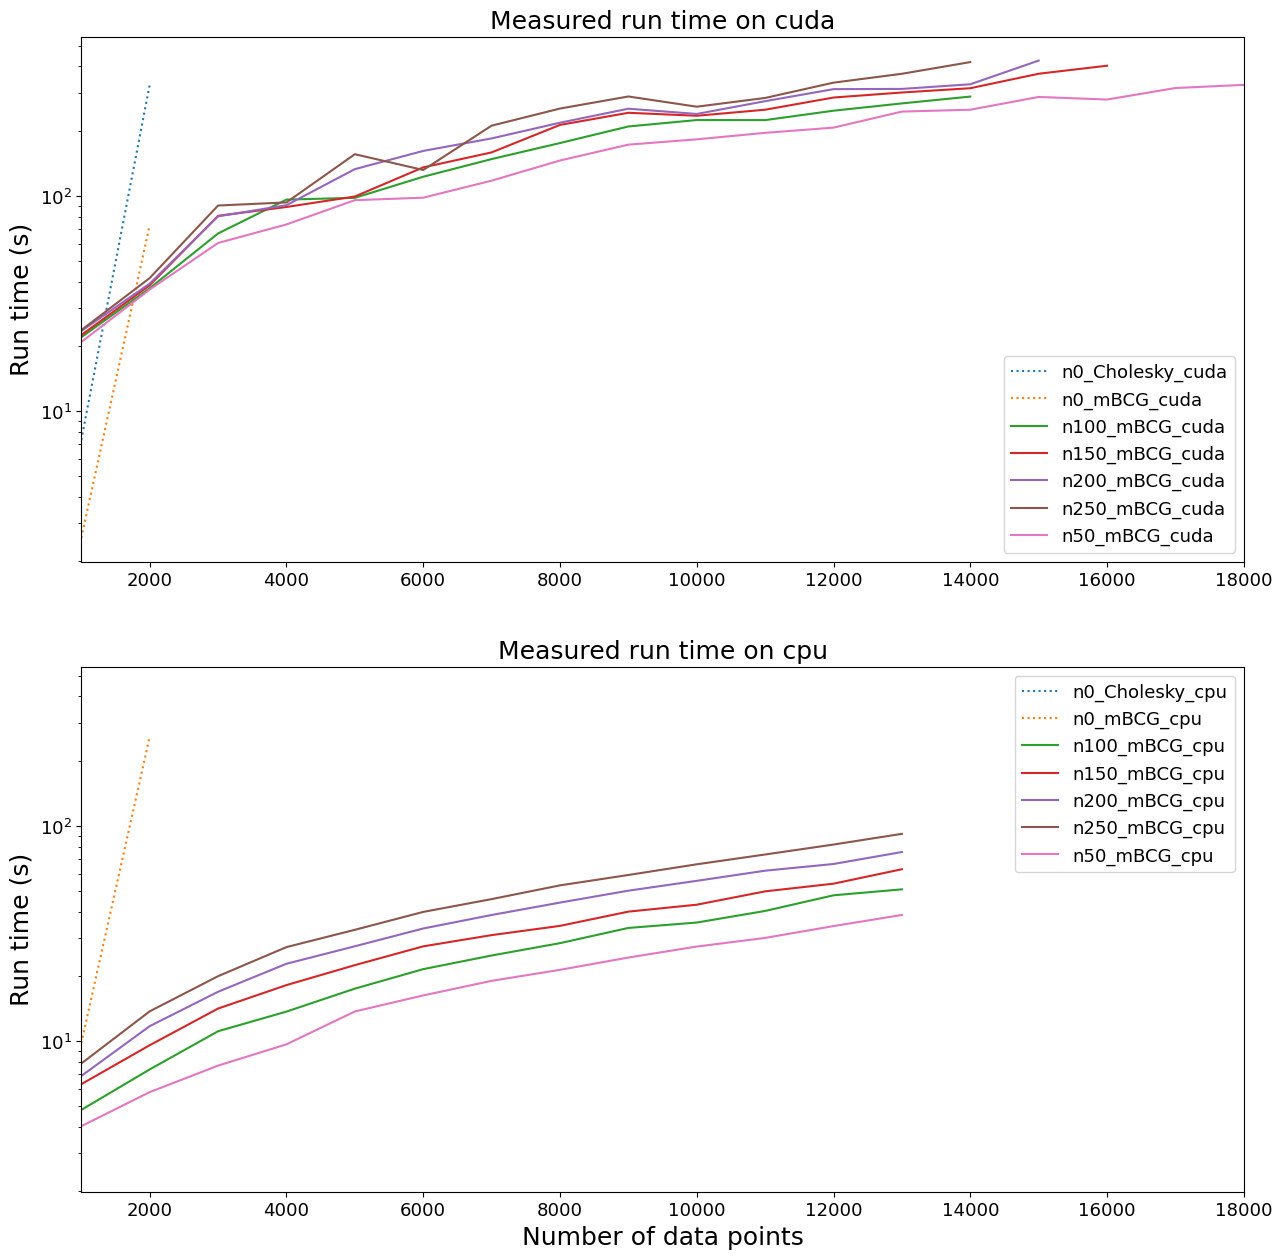

In [142]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharex=True, sharey=True)
for i, device in enumerate(["cuda", "cpu"]):
    for label, df_grouped in df[df.gp_id.str.contains(device)].groupby("gp_id"):
        style = "-"
        df_grouped.plot(
            x="data_points",
            y="run_time",
            kind="line",
            style=":" if "n0" in label else "-",
            logy=True,
            ax=axs[i],
            label=label,
            xlabel="Number of data points",
            ylabel="Run time (s)",
            title="Measured run time on " + device,
        )
plt.xlim(min(df.data_points), max(df.data_points))
axs[0].tick_params(labelbottom=True)

In [143]:
dfs = []
for i, device in enumerate(["cuda", "cpu"]):
    for label, df_grouped in df[df.gp_id.str.contains(device)].groupby("data_points"):
        chol_covar = None
        mbcg_covar = None
        rmse_chol = []
        rmse_mbcg = []
        for run_id in df_grouped.index:
            fp = COVAR_DIR_PATH / f"{run_id}.pt"
            if fp.is_file():
                if "Cholesky" in run_id:
                    chol_covar = torch.load(fp)
                    rmse_chol.append(nan)
                    rmse_mbcg.append(nan)
                    continue

                covar = torch.load(fp)
                if "n0_mBCG" in run_id:
                    mbcg_covar = covar

                if chol_covar is not None:
                    rmse_chol.append(torch.sqrt(torch.mean((chol_covar - covar) ** 2)).item())
                else:
                    rmse_chol.append(nan)

                if mbcg_covar is not None and "n0_mBCG" not in run_id:
                    rmse_mbcg.append(torch.sqrt(torch.mean((mbcg_covar - covar) ** 2)).item())
                else:
                    rmse_mbcg.append(nan)
            else:
                rmse_chol.append(nan)
                rmse_mbcg.append(nan)
        df_grouped["rmse_chol"] = rmse_chol
        df_grouped["rmse_mbcg"] = rmse_mbcg
        dfs.append(df_grouped[(df_grouped.rmse_chol.notnull() | df_grouped.rmse_mbcg.notnull())])

pd.concat(dfs)


,run_time,data_points,gp_id,rmse_chol,rmse_mbcg
run_id,,,,,
N1000_n0_mBCG_cuda,2.569687,1000,n0_mBCG_cuda,1.170847,NaN
N1000_n50_mBCG_cuda,20.936553,1000,n50_mBCG_cuda,10.514957,10.434665
N1000_n100_mBCG_cuda,22.019157,1000,n100_mBCG_cuda,17.955230,18.908115
N1000_n150_mBCG_cuda,22.545230,1000,n150_mBCG_cuda,3.586391,4.592665
N1000_n200_mBCG_cuda,23.534659,1000,n200_mBCG_cuda,24.989625,26.050303
N1000_n250_mBCG_cuda,23.770333,1000,n250_mBCG_cuda,3.531571,4.419757
N2000_n0_mBCG_cuda,73.147784,2000,n0_mBCG_cuda,14.211754,NaN
N2000_n50_mBCG_cuda,36.709159,2000,n50_mBCG_cuda,9.410323,23.488946
N2000_n100_mBCG_cuda,37.216303,2000,n100_mBCG_cuda,3.474515,15.454263
